In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import yaml
import time
import os

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error


In [2]:
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [3]:
ulp_in_dir = '../../MBC/filtering_and_correction_analysis/merged_data'
deep_in_dir = '../../MBC/deepWGS_filtering_and_correction_analysis/merged_data'

In [4]:
uncorrected_stats_path = '../GC_correction/files/exclusion_filtered.uncorrected.tsv'
GC_corrected_stats_path = '../GC_correction/files/exclusion_filtered.GC_corrected.tsv'
GC_map_corrected_stats_path = '../GC_correction/files/exclusion_filtered.GC_map_corrected.tsv'


In [5]:
#import stat data
stat_dict = {'uncorrected':pd.read_csv(uncorrected_stats_path, sep='\t').set_index('site_name'),
             'GC_corrected': pd.read_csv(GC_corrected_stats_path, sep='\t').set_index('site_name'),
            'GC_map_corrected': pd.read_csv(GC_map_corrected_stats_path, sep='\t').set_index('site_name')}

In [6]:
deep_data = pd.DataFrame()
for item in os.listdir(deep_in_dir):
    if item.startswith('10000-sites_data_with_features') and item.endswith('.exclusion_filtered.txt'):
        print(item)
        current=pd.read_csv(deep_in_dir+'/'+item, sep='\t')
        _,correction,filtered,_ = item.rsplit('.',3)
        current['correction'] = correction
        current['filter'] = filtered

        deep_data = deep_data.append(current, ignore_index=True)

print('samples',len(deep_data['sample'].unique()))
print('sites',len(deep_data['site_name'].unique()))


10000-sites_data_with_features.uncorrected.exclusion_filtered.txt
10000-sites_data_with_features.GC_map_corrected.exclusion_filtered.txt
10000-sites_data_with_features.GC_corrected.exclusion_filtered.txt
samples 4
sites 377


In [7]:
ulp_data = pd.DataFrame()
for item in os.listdir(ulp_in_dir):
    if item.startswith('10000-sites_data_with_features') and item.endswith('.exclusion_filtered.txt'):
        current=pd.read_csv(ulp_in_dir+'/'+item, sep='\t')
        _,correction,filtered,_ = item.rsplit('.',3)
        current['correction'] = correction
        current['filter'] = filtered
        current = current[(current['tumor_fraction']>=0.1) & (current['ulp_wgs_coverage']>=0.1) ]

        ulp_data = ulp_data.append(current, ignore_index=True)

print('samples',len(ulp_data['sample'].unique()))
print('sites',len(ulp_data['site_name'].unique()))


samples 191
sites 377


In [8]:
site_names = list(ulp_data['site_name'].unique())
print('sites',len(site_names))

sites 377


In [9]:
deep_samples = deep_data['sample'].unique()
colors = np.where(['MBC' in m for m in deep_samples],'tab:orange','tab:green')
color_dict = pd.DataFrame([deep_samples,colors]).T.rename(columns = {0:'sample',1:'color'}).set_index('sample')
color_dict = color_dict.to_dict()['color']

In [10]:
ulp_data['site_name']

0             AHR.hg38.10000
1              AR.hg38.10000
2          ARID3A.hg38.10000
3            ARNT.hg38.10000
4           ARNTL.hg38.10000
                 ...        
216016     ZNF792.hg38.10000
216017    ZSCAN16.hg38.10000
216018    ZSCAN22.hg38.10000
216019     ZSCAN4.hg38.10000
216020     ZSCAN9.hg38.10000
Name: site_name, Length: 216021, dtype: object

In [11]:
# blood_TFs = ['SPI1', 'CEBPD', 'MLX', 'E2F4', 'CEBPB', 'NFIL3', 'RXRA', 'FLI1', 'ELF4', 'ARID3A', 'MAX', 'TFEB', 'ZNF335',
#              'ZBTB48', 'PBX2', 'STAT5B', 'STAT6', 'BCL6', 'GFI1B', 'LYL1', 'NFE2', 'GATA1', 'MNT', 'KLF1', 'TAL1', 'POU2F2', 
#              'STaAT4', 'MECP2', 'RXRB', 'USF2', 'MAFG', 'ZBTB17', 'JUNB', 'USF1', 'NFYC', 'TBX21', 'NR1H2', 'RBPJ', 'ARNTL', 
#              'ZNF316', 'IRF1', 'IRF2', 'IKZF1', 'FOSL2', 'TFE3', 'ZEB2', 'NFKB2', 'MEF2B', 'ZNF18', 'ZNF467', 'IRF3', 'STAT5A',
#              'CXXC1', 'GFI1', 'RUNX3', 'PBX4', 'KLF6', 'ERF', 'STAT3', 'TCF7', 'DDIT3', 'BACH1', 'MXI1', 'CEBPA', 'ESR2', 'ESRRA',
#              'RARA', 'ZBTB16', 'RELB', 'PRDM1', 'EOMES', 'HIF1A', 'JUND', 'FOS', 'BCL11B', 'BATF', 'PAX5', 'SPIB', 'IRF4', 'POU5F1', 'ASCL2', 'BCL11A']
# print(len(blood_TFs))

# cancer_TFs = ['ETV1', 'SPDEF', 'CLOCK', 'E2F6', 'TBX5', 'NR5A2', 'ZFP64', 'PRDM6', 'ETV4', 'AR', 'ZNF680', 'SMAD1', 'OSR2',
#               'SOX13', 'ZBTB42', 'THRB', 'MEIS2', 'TRPS1', 'YY2', 'SMAD5', 'OVOL2', 'EHF', 'TWIST1', 'TFAP2A', 'TFAP2C',
#               'SOX4', 'TEAD1', 'SOX9', 'ELF3', 'HOXC9', 'NR2F2', 'NR2F6', 'SNAI2', 'TEAD3', 'FOXA1', 'ZNF146', 'HES1',
#               'MECOM', 'TEAD4', 'NFIB', 'PBX1', 'SIX5', 'TBX2', 'GRHL2', 'ZFHX2', 'ZFHX3', 'EPAS1', 'EBF3', 'ETV5',
#               'GLIS2', 'NR2F1', 'SIX2', 'SOX17', 'TCF4', 'NFIA', 'RBAK', 'NFIC', 'PATZ1', 'HNF4G', 'RARG', 'HES2',
#               'ZFP1', 'GLIS3', 'ZKSCAN1', 'PGR', 'GATA3', 'GATA6', 'HEY1', 'TCF12', 'HOXC5', 'ESR1', 'EGR2', 'XBP1',
#               'MYCN', 'SOX5', 'ZNF382', 'MYB', 'HAND2', 'GLIS1', 'MITF', 'EGR1', 'E2F7', 'EBF1', 'FOXH1', 'TP63', 'PROX1',
#               'SP5', 'HOXA6', 'TP73', 'ERG', 'WT1', 'TCF7L1', 'FOXM1', 'ZNF770', 'E2F8', 'MSC', 'HLF', 'ONECUT2',
#               'NKX3-1', 'EGR3', 'HOXB13', 'TLX1', 'ZIC2', 'PAX3', 'ASCL1', 'PAX7', 'FOXA3']
# print(len(cancer_TFs))


ZBTB16.hg38.10000
191
191
191


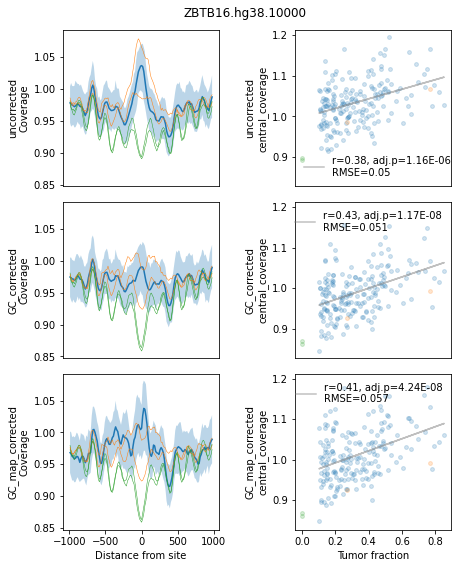

In [12]:
feature = 'central_coverage'
marker_size = 15

# for site_name in blood_TFs:
#     site_name = site_name+ '.hg38.10000'
for site_name in ['ZBTB16.hg38.10000']:
    print(site_name)
    fig,axes = plt.subplots(3,2, figsize = (7,8), sharey = 'col')
    for filtered in ['exclusion_filtered']: 
        for j,correction in enumerate(['uncorrected','GC_corrected','GC_map_corrected']):
            current_data = ulp_data[(ulp_data['filter']==filtered) & (ulp_data['correction']==correction)]
            current_data = current_data[current_data['site_name']==site_name]
            print(len(current_data))
            axes[j,0].plot(plot_columns, current_data[str_plot_columns].mean(axis=0))
            axes[j,0].fill_between(plot_columns, np.percentile(current_data[str_plot_columns],25, axis = 0), np.percentile(current_data[str_plot_columns],75, axis = 0), alpha=0.3)
            axes[j,0].set_ylabel(correction)
                        
            #add correlations
            axes[j,1].scatter(current_data['tumor_fraction'], current_data[feature], color = 'tab:blue', alpha = 0.2, s = marker_size)
            axes[j,0].set_ylabel(correction+'\nCoverage')
            
            #add line of best fit
            lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current_data['tumor_fraction'], current_data[feature])
            fit_line = lin_reg_slope*current_data['tumor_fraction']+lin_reg_intercept
            RMSE = np.sqrt(mean_squared_error(current_data[feature],fit_line))
            pearson_r = str(np.round(pearson_r,2))
            #pval = '{:.2E}'.format(pearson_pval)
            pval = stat_dict[correction].loc[site_name]['pearson-adjusted-p-val_central_coverage']
            pval = '{:.2E}'.format(pval)
            RMSE_str = str(np.round(RMSE,3))
            axes[j,1].plot(current_data['tumor_fraction'],fit_line, color= 'grey', alpha = 0.5, label = 'r='+pearson_r+', adj.p='+pval+'\nRMSE='+RMSE_str)
            axes[j,1].legend()
            axes[j,1].legend(frameon=False)
            axes[j,1].set_ylabel(correction+'\n'+feature)

            #add deep data
            for sample in deep_samples:
                current_deep_data = deep_data[(deep_data['filter']==filtered) & (deep_data['correction']==correction)]
                current_deep_data = current_deep_data[(current_deep_data['site_name']==site_name) & (current_deep_data['sample']==sample)]
                
                #cov profile
                axes[j,0].plot(plot_columns, current_deep_data[str_plot_columns].T, linewidth = .5, color = color_dict[sample])

                #feature scatter
                axes[j,1].scatter(current_deep_data['tumor_fraction'], current_deep_data[feature], color = color_dict[sample], alpha = 0.2, s = marker_size)

    for i in range(2):
        axes[0,i].tick_params(labelbottom=False, bottom=False)
        axes[1,i].tick_params(labelbottom=False, bottom=False)
    axes[2,0].set_xlabel('Distance from site')
    axes[2,1].set_xlabel('Tumor fraction')

    for i in range(2):
        for j in range(3):
            axes[j,i].set_aspect(1.0/axes[j,i].get_data_ratio(), adjustable='box')            
            
    fig.suptitle(site_name)
    fig.tight_layout()
    plt.savefig('plots/'+site_name+'.cov_profiles.pdf')
    